In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D 
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
import math

# root dir
# data root dir
# train data root dir
# test data root dir

In [ ]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

# Google Drive 마운트해서 데이터셋 가져옴

In [ ]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


In [ ]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    
    shutil.copy(os.path.join(dataset_path, 'brain_tumor.zip'), '/content')

except Exception as err:
    print(str(err))

In [ ]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
    
    shutil.rmtree(DATA_ROOT_DIR)
    
    print(DATA_ROOT_DIR + ' is removed !!!')

In [ ]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'brain_tumor.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR) 

# brain_tumor/Testing 확인
# brain_tumor/Training 확인

In [ ]:
import os

#========================================================
# train 정답 및 전체 데이터 개수 확인
#========================================================

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#========================================================
# test 정답 및 전체 데이터 개수 확인
#========================================================

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:

    print('test label : ', label_name, ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
train label :  glioma_tumor  =>  826
train label :  meningioma_tumor  =>  822
train label :  pituitary_tumor  =>  827
train label :  no_tumor  =>  395
['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
test label :  glioma_tumor  =>  100
test label :  meningioma_tumor  =>  115
test label :  pituitary_tumor  =>  74
test label :  no_tumor  =>  105


# 이미지 shape 설정

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# ImageDataGenerator 이용하여 데이터 불러옴

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='training')


validation_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='validation')

test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


# 32 개의 데이터와 정답 가져와서 16개 출력

In [ ]:
IMG_NUMS = 16

image_data, label_data = train_generator.next()

data = image_data[:IMG_NUMS]

label = label_data[:IMG_NUMS]

print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[3. 3. 2. 2. 0. 2. 1. 0. 1. 3. 1. 2. 1. 2. 3. 3.]


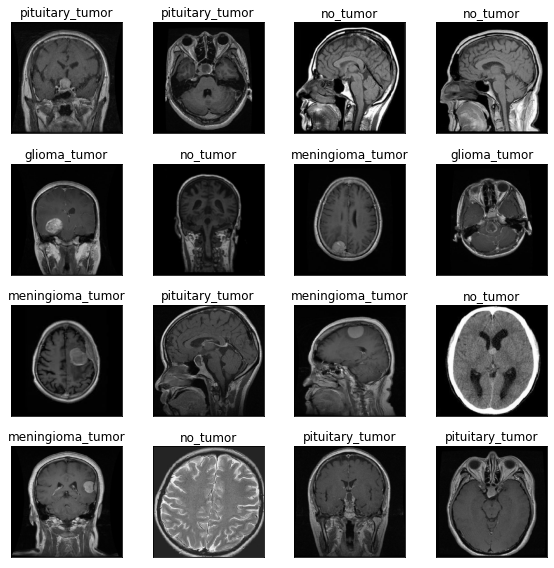

In [ ]:
import matplotlib.pyplot as plt

class_dict = { 0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}

plt.figure(figsize=(8, 8))

for i in range(len(label)):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[label[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(data[i])

plt.tight_layout()
plt.show()

# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [ ]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

pre_trained_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
class_nums = train_generator.num_classes  # 정답개수

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
                              verbose=1)


start_time = datetime.now()

hist = model.fit(train_generator, epochs=30, validation_data=validation_generator)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/30
72/72 [==============================] - 42s 394ms/step - loss: 1.5851 - acc: 0.3983 - val_loss: 1.1031 - val_acc: 0.5253
Epoch 2/30
72/72 [==============================] - 27s 367ms/step - loss: 1.0370 - acc: 0.5738 - val_loss: 1.0455 - val_acc: 0.5253
Epoch 3/30
72/72 [==============================] - 26s 366ms/step - loss: 0.7670 - acc: 0.7013 - val_loss: 0.9801 - val_acc: 0.5480
Epoch 4/30
72/72 [==============================] - 27s 367ms/step - loss: 0.6245 - acc: 0.7519 - val_loss: 0.8789 - val_acc: 0.6143
Epoch 5/30
72/72 [==============================] - 27s 368ms/step - loss: 0.5533 - acc: 0.7989 - val_loss: 0.7170 - val_acc: 0.7103
Epoch 6/30
72/72 [==============================] - 27s 368ms/step - loss: 0.4517 - acc: 0.8324 - val_loss: 0.5313 - val_acc: 0.8133
Epoch 7/30
72/72 [==============================] - 27s 368ms/step - loss: 0.4026 - acc: 0.8481 - val_loss: 0.4676 - val_acc: 0.8517
Epoch 8/30
72/72 [==============================] - 27s 371ms/step - 

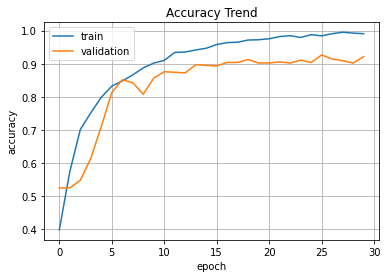

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

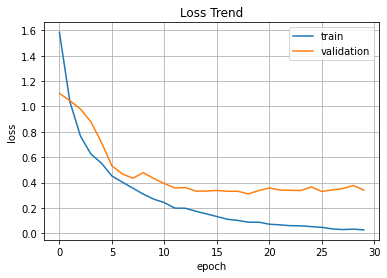

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.evaluate(test_generator)

13/13 [==============================] - 2s 166ms/step - loss: 1.6367 - acc: 0.7360


[1.6366639137268066, 0.7360405921936035]